# 1-step Forecasting with linear and non-linear models

In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import linear_model as lm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import utils

# Plot settings
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [3]:
# Loading alcohol data
train_df, test_df, data_raw_list = utils.load_alcohol()

combined_data = []

for i in range(len(train_df)):
    train = train_df[i]
    test = test_df[i]
    # Combine both train and test sets since the initial split was 50/50
    combined = pd.concat([train, test])
    # Sort by date
    combined['start'] = pd.to_datetime(combined['start'])
    combined = combined.sort_values(by='start')
    combined_data.append(combined)

combined_data[0].head()

,Unnamed: 0,ID,start,finish,drinks,comfortable,stressed,down,calm,pressure,...,cosT.1,sinT.1,cos2T.1,sin2T.1,cosW.1,sinW.1,dayvar.1,beepvar.1,filter.1,consec.1
0,1,1,2018-02-06 16:20:00,2/6/2018 16:22,3,7.382609,-9.817391,10.843478,-37.791304,6.173913,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1,4,0,1
31,2,1,2018-02-06 18:54:00,2/6/2018 18:58,0,14.382609,47.182609,7.843478,7.208696,10.173913,...,0.892979,0.450098,0.594823,0.803857,0.997777,0.066647,1,5,0,2
1,3,1,2018-02-06 20:08:00,2/6/2018 20:22,0,15.382609,12.182609,10.843478,20.208696,18.173913,...,0.418660,0.908143,-0.649448,0.760406,0.986795,0.161973,1,6,0,3
2,4,1,2018-02-06 22:29:00,2/6/2018 22:46,0,21.382609,-5.817391,-2.156522,8.208696,5.173913,...,0.108867,0.994056,-0.976296,0.216440,0.978277,0.207302,1,7,0,4
36,5,1,2018-02-07 10:52:00,2/7/2018 11:23,0,-11.617391,5.182609,0.843478,-24.791304,-4.826087,...,0.043619,-0.999048,-0.996195,-0.087156,0.777930,0.628351,2,1,0,7


In [4]:
# Loading covid data
covid_train_x_list, covid_test_x_list, covid_train_y_list, covid_test_y_list = utils.patients_covid()

covid_train_x_list[0].head()

55
Patient included in study:
[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 15, 16, 17, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 46, 48, 49, 50, 52, 53, 54, 55, 58, 59, 63, 64, 65, 66, 68, 70, 71, 72, 74, 75, 77]


,Relax_lag,Irritable_lag,Worry_lag,Nervous_lag,Future_lag,Anhedonia_lag,Tired_lag,Hungry_lag,Alone_lag,Angry_lag,Social_offline_lag,Social_online_lag,Music_lag,Procrastinate_lag,Outdoors_lag,C19_occupied_lag,C19_worry_lag,Home_lag,beepvar_lag
105,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,3.0,4.0,2.0,3.0,1.0,2.0,2.0,5.0,1.0
111,2.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0,2.0,2.0,5.0,3.0
109,2.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0
102,2.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,2.0,4.0,3.0,3.0,4.0,2.0
107,2.0,2.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,4.0,2.0,1.0,1.0,3.0,3.0,5.0,3.0


## 1. Idiographic Models Regression

In [5]:
# Predict craving

# Make own splits
def prepare_data_own(idx, combined_list, random_state):
    # print('Patient ID:', combined_list[idx].iloc[0]['ID'])
    X = combined_list[idx].drop(combined_list[idx].columns[range(0, 24)], axis=1).fillna(0)
    y = combined_list[idx]['craving']

    return train_test_split(X, y, test_size=0.3, random_state=random_state)


# Split into dependent/independent features
def prepare_data(idx, train_list, test_list):
    # print('Patient ID:', train_list[idx]['ID'][0])

    X_train = train_list[idx].drop(train_list[idx].columns[range(0, 61)], axis=1).fillna(0)
    y_train = train_list[idx]['craving']
    X_test = test_list[idx].drop(test_list[idx].columns[range(0, 61)], axis=1).fillna(0)
    y_test = test_list[idx]['craving']

    return X_train, X_test, y_train, y_test

### 1.1 Elastic-Net Regression

In [6]:
X_train, X_test, y_train, y_test = prepare_data(1, train_list=train_df, test_list=test_df)


# Train an elastic-net model
# Tests sets here are fore testing purposes
def elastic_net(train_x, train_y, test_x, test_y, vis):
    # Standardize data
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)

    # Train model with 5-fold cross-validation
    l1_ratios = np.arange(0.01, 0.6, 0.05)
    elastic_reg = lm.ElasticNetCV(alphas=np.arange(0.01, 20, 0.05), l1_ratio=l1_ratios, cv=5, max_iter=100000,
                                  fit_intercept=True)
    elastic_reg.fit(X_train_loc, train_y)
    y_predicted_test = elastic_reg.predict(X_test_loc)
    # print('--- Elastic-Net Results ---')
    # print()
    # Show results for current test set if vis is set to True
    utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)

    return elastic_reg


m = elastic_net(X_train, y_train, X_test, y_test, True)

R_squared: 0.3105248292112299
MSE: 415.92726079626027
RMSE: 20.394294809977133
MAE: 16.71060148405697
CORR: 0.5610027960444378


### 1.2 Linear SVM Regression

In [7]:
def linear_svm(train_x, train_y, test_x, test_y, vis, params):
    # Standardize data
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)

    # Train over the hyperparameter grid with 5-fold CV
    clf = GridSearchCV(estimator=LinearSVR(), param_grid=params, scoring='neg_mean_absolute_error', cv=5)
    clf.fit(X_train_loc, train_y)
    # best_params = clf.best_params_
    # print(best_params)
    y_predicted_test = clf.predict(X_test_loc)

    # print('--- Linear-SVM Results ---')
    # print()
    utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)
    return clf


param = [
    {'C': np.arange(0.1, 4, 0.1),
     'epsilon': np.arange(6, 7, 0.1),
     'loss': ['epsilon_insensitive'],
     'fit_intercept': [True],
     'max_iter': [10000]}]

m = linear_svm(X_train, y_train, X_test, y_test, True, param)

R_squared: 0.3129070293370735
MSE: 414.49019385753775
RMSE: 20.359032242656767
MAE: 15.757418918150368
CORR: 0.5713803114290074


### 1.3 K-NN Regression

In [8]:
# k-Nearest Neighbors Model
def knn_reg(train_x, train_y, test_x, test_y, vis):
    params = [
        {'weights': ['uniform', 'distance'],
         'n_neighbors': np.arange(2, 20, 1)}]

    # Train with 5-fold CV
    clf = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params, scoring='neg_mean_absolute_error', cv=5)
    clf.fit(train_x, train_y)

    y_predicted_test = clf.predict(test_x)

    mse, rmse, mae = utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)
    return mse, rmse, mae


m = knn_reg(X_train, y_train, X_test, y_test, True)

R_squared: 0.1254204616378809
MSE: 527.591836734694
RMSE: 22.969367355995985
MAE: 17.183673469387752
CORR: 0.49538301761540343


### 1.4 XGBoost Regression

In [9]:
def xgboost_reg(train_x, train_y, test_x, test_y, vis):
    # Very simple models work better here, since there are few data points
    # Hyperparameter grid
    params = [
        {'objective': ['reg:squarederror'],
         'n_estimators': [1, 3, 5, 7, 10, 20, 30],
         'eval_metric': ['mae'],
         'max_depth': np.arange(1, 8, 1)}]

    # Train a model with 5-fold CV
    reg_xgb = GridSearchCV(xgb.XGBRegressor(), params, n_jobs=5, cv=5, scoring='neg_mean_absolute_error')
    reg_xgb.fit(train_x, train_y)

    # print(reg_xgb.best_params_)
    y_predicted_test = reg_xgb.predict(test_x)

    utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)
    return reg_xgb


m = xgboost_reg(X_train, y_train, X_test, y_test, True)

R_squared: 0.1821370000722441
MSE: 493.377472719434
RMSE: 22.21210194284715
MAE: 16.118310809097522
CORR: 0.5150857953119794


### 1.5 Random Forests

In [10]:

# Function to train a random forests model
def random_forests(train_x, train_y, test_x, test_y, vis):
    # Hyperparameter grid
    grid = [
        {'n_estimators': [25, 50, 70, 100],
         'max_features': ['auto', 'sqrt'],
         'max_depth': [3, 5, 10, 15],
         'min_samples_split': [2, 4, 6],
         'min_samples_leaf': [1],
         'bootstrap': [True]}]

    # Train with 5-fold CV
    rf = GridSearchCV(RandomForestRegressor(), param_grid=grid, cv=5, scoring='neg_mean_absolute_error')
    rf.fit(train_x, train_y)
    y_predicted_test = rf.predict(test_x)
    # print(rf.best_params_)

    utils.eval_results(actual=test_y, predicted=y_predicted_test, show=vis)

    return rf


m = random_forests(X_train, y_train, X_test, y_test, True)

R_squared: 0.2605188548771914
MSE: 446.09346374220615
RMSE: 21.12092478425616
MAE: 16.35408875931325
CORR: 0.5487014758480252


### 1.6 3-Layer LSTM RNN

In [11]:
import keras.layers as layer
from keras.models import Sequential


# Train a NN with 3 LSTM units
def lstm_rnn(train_x, train_y, test_x, test_y, vis):
    # Standardize and transform both the train and test sets
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)
    train_x_val, train_y_val, test_x_val, test_y_val = X_train_loc.values, train_y.values, X_test_loc.values, test_y.values

    train_x_val = train_x_val.reshape((train_x_val.shape[0], 1, train_x_val.shape[1]))
    test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))

    # Neural network architecture
    model = Sequential([
        layer.Input(shape=(train_x_val.shape[1], train_x_val.shape[2])),
        layer.LSTM(40, return_sequences=True),
        layer.Dropout(0.25),
        layer.LSTM(units=25, return_sequences=True),
        layer.Dropout(0.20),
        layer.LSTM(units=10, return_sequences=False),
        layer.Dense(units=1, activation='linear')
    ])
    # Compile and train model
    model.compile(loss='mae', optimizer='adam')
    model.fit(train_x_val, train_y_val, epochs=40, batch_size=4, verbose=0, shuffle=False)

    y_predicted_test = model.predict(test_x_val)

    utils.eval_results(actual=test_y, predicted=y_predicted_test.flatten(), show=vis)

    return model


m = lstm_rnn(X_train, y_train, X_test, y_test, True)

R_squared: 0.1056308421350346
MSE: 539.5299638504285
RMSE: 23.227784307816115
MAE: 20.153607050566226
CORR: 0.5090980836674411


### 1.7 1-Layer LSTM RNN

In [12]:
# Train a NN with 1 LSTM unit
def one_lstm_rnn(train_x, train_y, test_x, test_y, vis):
    # Standardize and transform both the train and test sets
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)
    train_x_val, train_y_val, test_x_val, test_y_val = X_train_loc.values, train_y.values, X_test_loc.values, test_y.values

    train_x_val = train_x_val.reshape((train_x_val.shape[0], 1, train_x_val.shape[1]))
    test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))

    # Neural network architecture
    model = Sequential([
        layer.Input(shape=(train_x_val.shape[1], train_x_val.shape[2])),
        layer.Bidirectional(layer.LSTM(32, return_sequences=True)),
        layer.Dropout(0.25),
        layer.Dense(units=1, activation='linear')
    ])
    # Compile and train model
    model.compile(loss='mae', optimizer='adam')
    model.fit(train_x_val, train_y_val, epochs=40, batch_size=4, verbose=0, shuffle=False)

    y_predicted_test = model.predict(test_x_val)

    utils.eval_results(actual=test_y, predicted=y_predicted_test.flatten(), show=vis)

    return model


m = one_lstm_rnn(X_train, y_train, X_test, y_test, True)

R_squared: 0.10186356980142941
MSE: 541.8025783386303
RMSE: 23.27665307424223
MAE: 19.371372209558867
CORR: 0.5053716008343186


### 1.8 Gated Recurrent Unit (GRU) Network

In [13]:
# Train a NN with GRU units
def gru_rnn(train_x, train_y, test_x, test_y, vis):
    # Standardize and transform both the train and test sets
    X_train_loc = utils.standardize(train_x).fillna(0)
    X_test_loc = utils.standardize(test_x).fillna(0)
    train_x_val, train_y_val, test_x_val, test_y_val = X_train_loc.values, train_y.values, X_test_loc.values, test_y.values

    train_x_val = train_x_val.reshape((train_x_val.shape[0], 1, train_x_val.shape[1]))
    test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))

    # Neural network architecture
    model = Sequential([
        layer.Input(shape=(train_x_val.shape[1], train_x_val.shape[2])),
        layer.Bidirectional(layer.GRU(units=24)),
        layer.RepeatVector(train_x_val.shape[1]),
        layer.Bidirectional(layer.GRU(units=24, return_sequences=True)),
        layer.TimeDistributed(layer.Dense(units=1, activation='linear'))
    ])
    # Compile and train model
    model.compile(loss='mae', optimizer='adam')
    model.fit(train_x_val, train_y_val, epochs=60, batch_size=4, verbose=0, shuffle=False)

    y_predicted_test = model.predict(test_x_val)

    utils.eval_results(actual=test_y, predicted=y_predicted_test.flatten(), show=vis)

    return model


m = gru_rnn(X_train, y_train, X_test, y_test, True)

R_squared: -0.072907774676638
MSE: 647.233737652578
RMSE: 25.440788856727263
MAE: 20.24282703240813
CORR: 0.2670193094698523


### 2.1 Evaluating Performance on Entire Dataset (Alcohol Data)

In [14]:
import warnings


# Function to evaluate the models on the 'Alcohol' dataset
def evaluate_models(train_list, test_list):
    assert len(train_list) == len(test_list)
    # Lists to hold the metrics for all patients and models
    mse_elastic, mse_svm, mse_one_lstm, mse_xgb, mse_rf, mse_lstm, mse_gru = ([] for _ in range(7))
    rmse_elastic, rmse_svm, rmse_one_lstm, rmse_xgb, rmse_rf, rmse_lstm, rmse_gru = ([] for _ in range(7))
    mae_elastic, mae_svm, mae_one_lstm, mae_xgb, mae_rf, mae_lstm, mae_gru = ([] for _ in range(7))

    patient_ids = []
    # Write out the results to a text file
    f = open("output_idiographic_a.txt", "a")
    f.write('- - - PER INDIVIDUAL RESULTS - - -\n')
    for x in range(len(train_list)):
        # Build and evaluate a model for every single patient
        train_x, test_x, train_y, test_y = prepare_data(x, train_list=train_list, test_list=test_list)
        # Elastic-Net (baseline)
        elastic = elastic_net(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, elastic.predict(utils.standardize(test_x).fillna(0)), False)
        # Elastic-Net metrics
        patient_ids.append(train_list[x]['ID'][0])
        mse_elastic.append(mse)
        rmse_elastic.append(rmse)
        mae_elastic.append(mae)

        f.write("Patient ID: %s\n" % train_list[x]['ID'][0])
        f.write('\n')
        f.write('--- Elastic-Net ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # Linear-SVM

        params = [
            {'C': np.arange(0.1, 4, 0.1),
             'epsilon': np.arange(6, 7, 0.1),
             'loss': ['epsilon_insensitive'],
             'fit_intercept': [True],
             'max_iter': [10000]}]

        svm = linear_svm(train_x, train_y, test_x, test_y, False, params)
        mse, rmse, mae = utils.eval_results(test_y, svm.predict(utils.standardize(test_x).fillna(0)), False)
        # Linear-SVM metrics
        mse_svm.append(mse)
        rmse_svm.append(rmse)
        mae_svm.append(mae)

        f.write('--- Linear-SVM ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # XGBoost Regression
        xgboost = xgboost_reg(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, xgboost.predict(test_x), False)
        # XGBoost metrics
        mse_xgb.append(mse)
        rmse_xgb.append(rmse)
        mae_xgb.append(mae)

        f.write('--- XGBoost ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # RF
        rf = random_forests(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, rf.predict(test_x), False)
        # RF metrics
        mse_rf.append(mse)
        rmse_rf.append(rmse)
        mae_rf.append(mae)

        f.write('--- Random Forests ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # LSTM 3-Layer RNN
        test_x_val = utils.standardize(test_x).fillna(0).values
        test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))
        lstm = lstm_rnn(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, lstm.predict(test_x_val).flatten(),
                                            False)
        # LSTM metrics
        mse_lstm.append(mse)
        rmse_lstm.append(rmse)
        mae_lstm.append(mae)

        f.write('--- LSTM RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # LSTM 1-Layer RNN
        lstm_one = one_lstm_rnn(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, lstm_one.predict(test_x_val).flatten(), False)
        # LSTM metrics
        mse_one_lstm.append(mse)
        rmse_one_lstm.append(rmse)
        mae_one_lstm.append(mae)

        f.write('--- 1-LSTM RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # GRU RNN
        gru = gru_rnn(train_x, train_y, test_x, test_y, False)
        mse, rmse, mae = utils.eval_results(test_y, gru.predict(test_x_val).flatten(), False)

        # GRU metrics
        mse_gru.append(mse)
        rmse_gru.append(rmse)
        mae_gru.append(mae)

        f.write('--- GRU RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

    f.close()
    # Print out the average metrics for all models
    print('---- Elastic-Net Results ----')
    utils.average_metrics(mse_elastic, rmse_elastic, mae_elastic)
    print('---------------------------------')
    print('---- Linear SVM Results ----')
    utils.average_metrics(mse_svm, rmse_svm, mae_svm)
    print('---------------------------------')
    print('---- XGBoost Results ----')
    utils.average_metrics(mse_xgb, rmse_xgb, mae_xgb)
    print('---------------------------------')
    print('---- Random Forest Results ----')
    utils.average_metrics(mse_rf, rmse_rf, mae_rf)
    print('---------------------------------')
    print('---- LSTM Results ----')
    utils.average_metrics(mse_lstm, rmse_lstm, mae_lstm)
    print('---------------------------------')
    print('---- 1-LSTM Results ----')
    utils.average_metrics(mse_one_lstm, rmse_one_lstm, mae_one_lstm)
    print('---------------------------------')
    print('---- GRU Results ----')
    utils.average_metrics(mse_gru, rmse_gru, mae_gru)
    print('---------------------------------')

    print('Included patient list:')
    print(patient_ids)

    # For the box-plot later
    rmse_overall = rmse_elastic + rmse_svm + rmse_xgb + rmse_rf + rmse_lstm + rmse_one_lstm + rmse_gru
    n = len(rmse_rf)
    model_names = ['Elastic Net'] * n + ['SVM'] * n + ['XGBoost'] * n + ['RF'] * n + ['3-Layer LSTM'] * n + [
        '1-Layer LSTM'] * n + ['GRU'] * n
    dataset = ['Alcohol'] * len(model_names)
    mae_overall = mae_elastic + mae_svm + mae_xgb + mae_rf + mae_lstm + mae_one_lstm + mae_gru

    return mae_overall, rmse_overall, model_names, dataset


warnings.filterwarnings("ignore")
mae_alcohol, rmse_alcohol, models_alcohol, data_alcohol = evaluate_models(train_df, test_df)

---- Elastic-Net Results ----
Average MSE: 284.289072940186
Average RMSE: 14.771363649360774
Average MAE: 10.985510678456176
---------------------------------
---- Linear SVM Results ----
Average MSE: 256.88566419601915
Average RMSE: 14.318327413026973
Average MAE: 10.33512245035132
---------------------------------
---- XGBoost Results ----
Average MSE: 296.72527970828395
Average RMSE: 15.398592744621979
Average MAE: 10.916741750513548
---------------------------------
---- Random Forest Results ----
Average MSE: 265.686646407106
Average RMSE: 14.529397062192318
Average MAE: 10.443565144681482
---------------------------------
---- LSTM Results ----
Average MSE: 297.58450595901786
Average RMSE: 15.587776128054246
Average MAE: 10.462110656710392
---------------------------------
---- 1-LSTM Results ----
Average MSE: 314.0164845983105
Average RMSE: 16.035706593331646
Average MAE: 10.849011089525849
---------------------------------
---- GRU Results ----
Average MSE: 341.8673838031492
Av

### 2.2 Evaluating Performance on Entire Dataset (COVID-19 Data)

In [15]:
# Function to evaluate the models on the COVID-19 dataset
def evaluate_models(covid_train_x, covid_test_x, covid_train_y, covid_test_y):
    # Lists to hold the metrics for all patients and models
    mse_elastic, mse_svm, mse_one_lstm, mse_xgb, mse_rf, mse_lstm, mse_gru = ([] for _ in range(7))
    rmse_elastic, rmse_svm, rmse_one_lstm, rmse_xgb, rmse_rf, rmse_lstm, rmse_gru = ([] for _ in range(7))
    mae_elastic, mae_svm, mae_one_lstm, mae_xgb, mae_rf, mae_lstm, mae_gru = ([] for _ in range(7))

    # Write the results to a text file
    f = open("output_idiographic_c.txt", "a")
    f.write('- - - PER INDIVIDUAL RESULTS - - -\n')

    for z in range(len(covid_train_x_list)):
        # Build and evaluate a model for every single patient

        # Elastic-Net (baseline)
        elastic = elastic_net(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y_list[z],
                                            elastic.predict(utils.standardize(covid_test_x_list[z]).fillna(0)),
                                            False)

        # Elastic-Net metrics
        mse_elastic.append(mse)
        rmse_elastic.append(rmse)
        mae_elastic.append(mae)

        f.write("Patient ID: %s\n" % z)
        f.write('\n')
        f.write('--- Elastic-Net ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # Linear-SVM

        params = [
            {'C': np.arange(0.1, 2, 0.1),
             'epsilon': np.arange(0, 0.5, 0.1),
             'loss': ['epsilon_insensitive'],
             'fit_intercept': [True],
             'max_iter': [10000]}]

        svm = linear_svm(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False, params)
        mse, rmse, mae = utils.eval_results(covid_test_y_list[z],
                                            svm.predict(utils.standardize(covid_test_x_list[z]).fillna(0)),
                                            False)
        # Linear-SVM metrics
        mse_svm.append(mse)
        rmse_svm.append(rmse)
        mae_svm.append(mae)

        f.write('--- Linear-SVM ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # XGBoost Regression
        xgb_covid = xgboost_reg(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y_list[z], xgb_covid.predict(covid_test_x_list[z]), False)
        # XGBoost metrics
        mse_xgb.append(mse)
        rmse_xgb.append(rmse)
        mae_xgb.append(mae)

        f.write('--- XGBoost ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # RF
        rf_covid = random_forests(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y_list[z], rf_covid.predict(covid_test_x_list[z]), False)
        # RF metrics
        mse_rf.append(mse)
        rmse_rf.append(rmse)
        mae_rf.append(mae)

        f.write('--- Random Forests ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # LSTM 3-Layer RNN
        test_x_val = utils.standardize(covid_test_x[z]).fillna(0).values
        test_x_val = test_x_val.reshape((test_x_val.shape[0], 1, test_x_val.shape[1]))
        lstm_covid = lstm_rnn(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y_list[z],
                                            lstm_covid.predict(test_x_val).flatten(),
                                            False)
        # LSTM metrics
        mse_lstm.append(mse)
        rmse_lstm.append(rmse)
        mae_lstm.append(mae)

        f.write('--- LSTM RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # LSTM 1-Layer RNN
        lstm1_covid = one_lstm_rnn(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y_list[z],
                                            lstm1_covid.predict(test_x_val).flatten(),
                                            False)
        # LSTM metrics
        mse_one_lstm.append(mse)
        rmse_one_lstm.append(rmse)
        mae_one_lstm.append(mae)

        f.write('--- 1-LSTM RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

        # GRU RNN
        gru = gru_rnn(covid_train_x[z], covid_train_y[z], covid_test_x[z], covid_test_y[z], False)
        mse, rmse, mae = utils.eval_results(covid_test_y_list[z], gru.predict(test_x_val).flatten(), False)

        # GRU metrics
        mse_gru.append(mse)
        rmse_gru.append(rmse)
        mae_gru.append(mae)

        f.write('--- GRU RNN ---\n')
        f.write("MSE: %s\n" % mse)
        f.write("RMSE: %s\n" % rmse)
        f.write("MAE: %s\n" % mae)
        f.write('\n')

    f.close()
    # Print out the average metrics for every model
    print('---- Elastic-Net Results ----')
    utils.average_metrics(mse_elastic, rmse_elastic, mae_elastic)
    print('---------------------------------')
    print('---- Linear SVM Results ----')
    utils.average_metrics(mse_svm, rmse_svm, mae_svm)
    print('---------------------------------')
    print('---- XGBoost Results ----')
    utils.average_metrics(mse_xgb, rmse_xgb, mae_xgb)
    print('---------------------------------')
    print('---- Random Forest Results ----')
    utils.average_metrics(mse_rf, rmse_rf, mae_rf)
    print('---------------------------------')
    print('---- LSTM Results ----')
    utils.average_metrics(mse_lstm, rmse_lstm, mae_lstm)
    print('---------------------------------')
    print('---- 1-LSTM Results ----')
    utils.average_metrics(mse_one_lstm, rmse_one_lstm, mae_one_lstm)
    print('---------------------------------')
    print('---- GRU Results ----')
    utils.average_metrics(mse_gru, rmse_gru, mae_gru)
    print('---------------------------------')

    # For the box-plot later
    rmse_overall = rmse_elastic + rmse_svm + rmse_xgb + rmse_rf + rmse_lstm + rmse_one_lstm + rmse_gru
    n = len(rmse_rf)
    model_names = ['Elastic Net'] * n + ['SVM'] * n + ['XGBoost'] * n + ['RF'] * n + ['3-Layer LSTM'] * n + [
        '1-Layer LSTM'] * n + ['GRU'] * n
    dataset = ['COVID-19'] * len(model_names)
    mae_overall = mae_elastic + mae_svm + mae_xgb + mae_rf + mae_lstm + mae_one_lstm + mae_gru

    return mae_overall, rmse_overall, model_names, dataset


mae_covid, rmse_covid, models_covid, data_covid = evaluate_models(covid_train_x_list, covid_test_x_list,
                                                                  covid_train_y_list,
                                                                  covid_test_y_list)

---- Elastic-Net Results ----
Average MSE: 0.5522561827799608
Average RMSE: 0.6788114939714779
Average MAE: 0.5291089375122295
---------------------------------
---- Linear SVM Results ----
Average MSE: 0.8465369992314881
Average RMSE: 0.8307309833935882
Average MAE: 0.6160906696837006
---------------------------------
---- XGBoost Results ----
Average MSE: 0.6299136725033335
Average RMSE: 0.7337463477865799
Average MAE: 0.5173483196531824
---------------------------------
---- Random Forest Results ----
Average MSE: 0.5551834195807028
Average RMSE: 0.6822996739429481
Average MAE: 0.510690746529322
---------------------------------
---- LSTM Results ----
Average MSE: 0.6567209377584792
Average RMSE: 0.7430418537183316
Average MAE: 0.5544137617089936
---------------------------------
---- 1-LSTM Results ----
Average MSE: 1.0018199295797956
Average RMSE: 0.9278613227699346
Average MAE: 0.7029169090493053
---------------------------------
---- GRU Results ----
Average MSE: 0.8148054049012

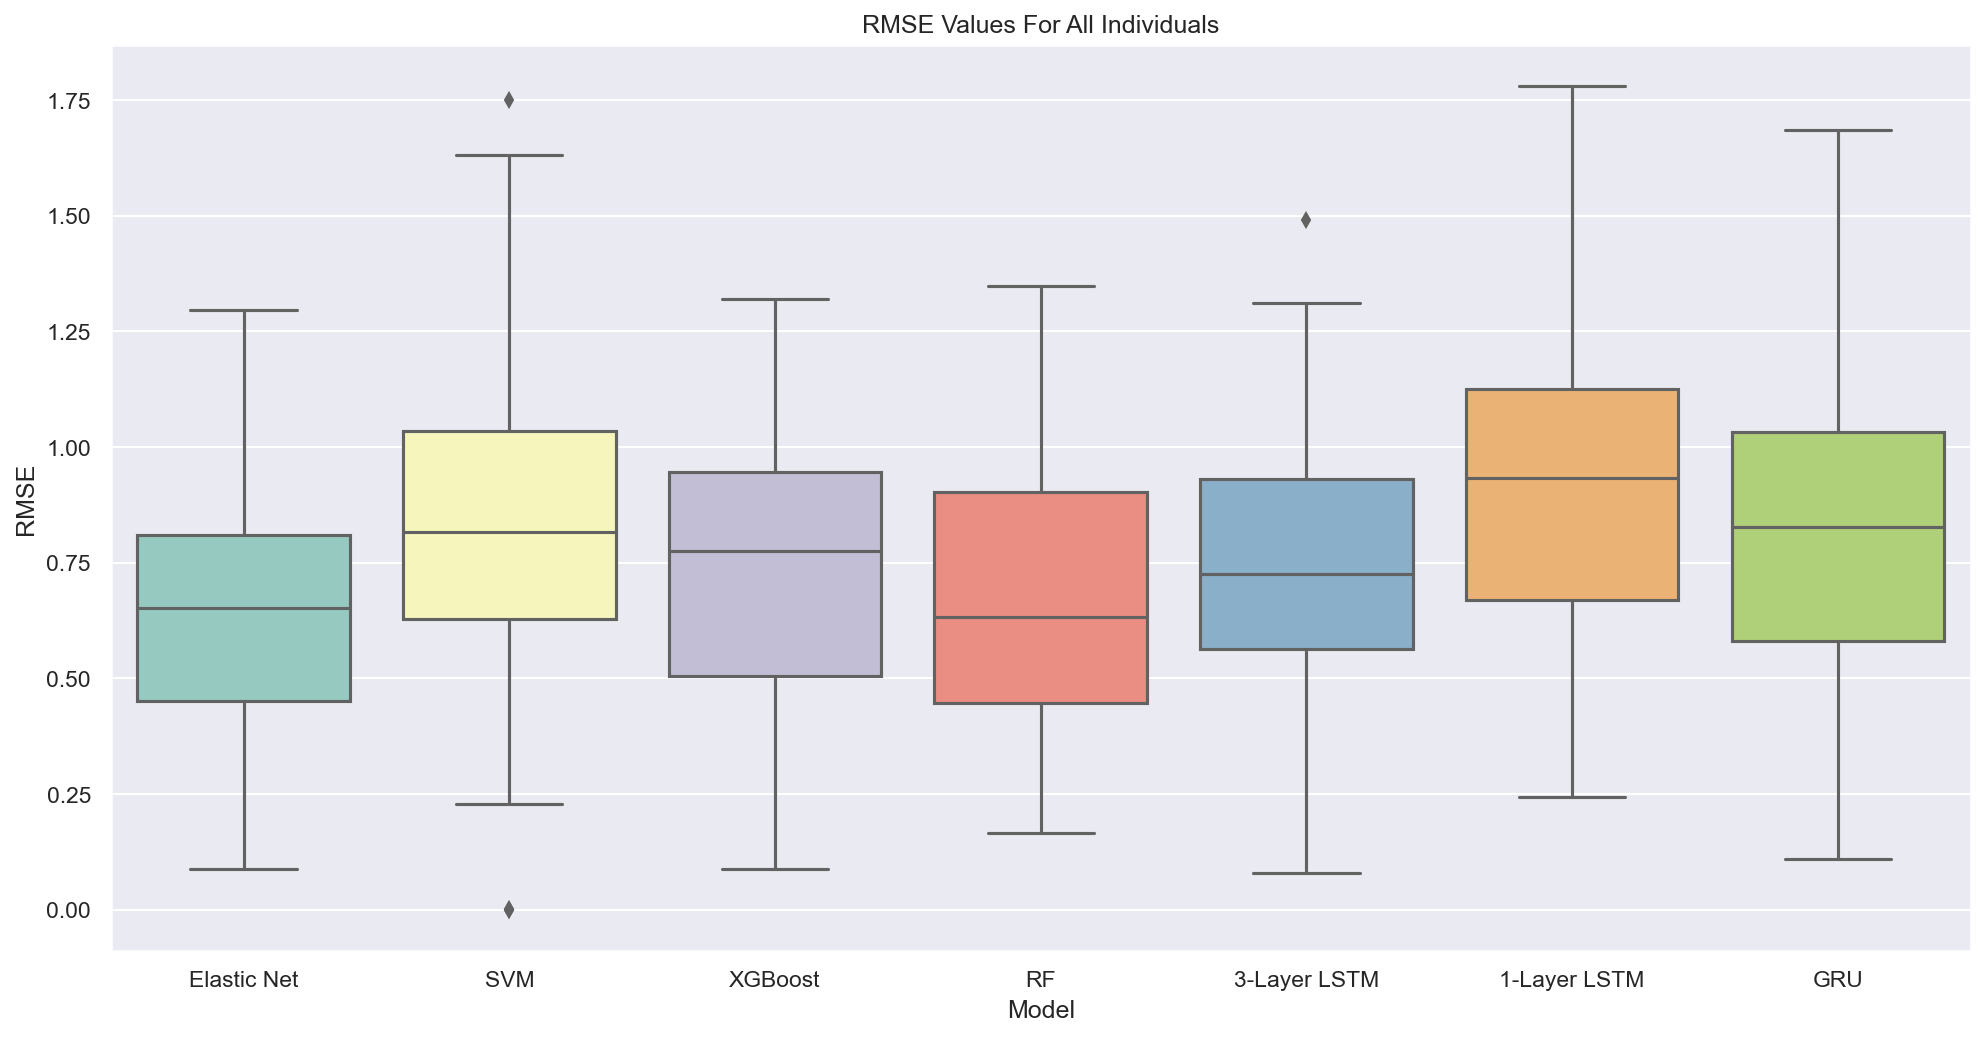

In [18]:
# Generate a box-plot for the RMSE values
mae = mae_alcohol + mae_covid
rmse = rmse_alcohol + rmse_covid
models = models_alcohol + models_covid
dataset_names = data_alcohol + data_covid

dictionary = {'MAE': mae, 'RMSE': rmse, 'Model': models, 'Dataset': dataset_names}
df = pd.DataFrame(data=dictionary)
#boxplot = sns.catplot(x='Model', y='RMSE', col='Dataset',
#data=df, kind="box",
#height=4, aspect=.7)
boxplot = sns.boxplot(data=df.loc[df['Dataset'] == 'COVID-19'], y='RMSE', x='Model', palette="Set3")
boxplot.set(title='RMSE Values For All Individuals', ylabel='RMSE')
df.to_csv('idiographic.csv')

### Nomothethic Approach In separate notebook